# Hierarchy Classification

`Disclaimer`: Este notebook debe ejecutarse con un Kernel de Python 3.10 (Tensorflow da problemas con Python 3.12)

Queremos implementar un solo modelo que incorpore jerarquías (por ejemplo, BENIGN → Web Attack → Subtipo de Web Attack), podemos usar un modelo multicapa jerárquico:

Entrenaremos un modelo con múltiples salidas, donde cada salida represente un nivel de la jerarquía.

Ejemplo:

    - Nivel 1: BENIGN vs MALICIOUS.

    - Nivel 2: Si es MALICIOUS, clasifica entre DDoS, PortScan, y WebAttack.

    - Nivel 3: Si es WebAttack, clasifica entre Brute Force, XSS, SQL Injection.

Esto puede implementarse usando redes neuronales con varias capas de salida o con varios modelos encadenados.


In [1]:
!python --version


Python 3.9.6


In [2]:
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install imbalanced-learn
#!pip install tensorflow

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2




/Users/nico/Desktop/UPC/PAE/SentinelX/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Preprocesado

Seguiremos el mismo preprocesado que en el documento anterior *DataAnalysis.ipynb*. Con la diferencia de que tendremos 3 datasets con la variable objetivo *"AttackType"* de mas a menos compactada.

In [4]:
dataDdos = pd.read_csv('Datasets/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
dataPortScan = pd.read_csv('Datasets/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
dataWebAttacks = pd.read_csv('Datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')

Como ya sabemos que los Datasets tienen las mismas variables, no hace falta volverlo a comprobar.

In [5]:
data = pd.concat([dataDdos, dataPortScan, dataWebAttacks], ignore_index=True)

data.rename(columns={' Label': 'AttackType'}, inplace=True)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
nan_values = data.isna().sum().sum()

data.dropna(inplace=True)

Como hemos visto anteriormente en las clases de Web Attack hay un caracter desconocido:
Web Attack � Brute Force, queremos sustituir � por -

In [6]:
data['AttackType'] = data['AttackType'].str.replace('�', '-')
data.columns = data.columns.str.strip()
print(data['AttackType'].value_counts())

AttackType
BENIGN                        393029
PortScan                      158804
DDoS                          128025
Web Attack - Brute Force        1507
Web Attack - XSS                 652
Web Attack - Sql Injection        21
Name: count, dtype: int64


Como hemos visto en el anterior estudio, hacer oversampling haciendo uso de SMOTE Algorithm para generar datos sintetico y balancear las clases ha funcionado bastante bien asi que volveremos a hacerlo.

In [7]:
X = data.drop(columns=['AttackType'])
y = data['AttackType']

## Nivel 1: BENIGN vs MALIGN

Para el primer nivel de jerarquia debemos detectar simplemente si hay o no amenaza. Para ello, compactaremos todas las clases de ataques en una sola clase llamada MALIGN y el modelo debera hacer la clasificación binaria.

In [8]:
target_classes = {
    "Web Attack - Brute Force": 50000,
    "Web Attack - XSS": 50000,
    "Web Attack - Sql Injection": 50000
}

smote = SMOTE(sampling_strategy=target_classes, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(y_resampled.value_counts())

AttackType
BENIGN                        393029
PortScan                      158804
DDoS                          128025
Web Attack - Brute Force       50000
Web Attack - XSS               50000
Web Attack - Sql Injection     50000
Name: count, dtype: int64


Ahora podemos compactar los distintos ataques en MALIGN obteniendo un dataset balanceado

In [9]:
y_resampled = y_resampled.apply(lambda x: 'MALIGN' if x != 'BENIGN' else x)
print(y_resampled.value_counts())

AttackType
MALIGN    436829
BENIGN    393029
Name: count, dtype: int64


### Random Forest

In [10]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     78505
      MALIGN       1.00      1.00      1.00     87467

    accuracy                           1.00    165972
   macro avg       1.00      1.00      1.00    165972
weighted avg       1.00      1.00      1.00    165972



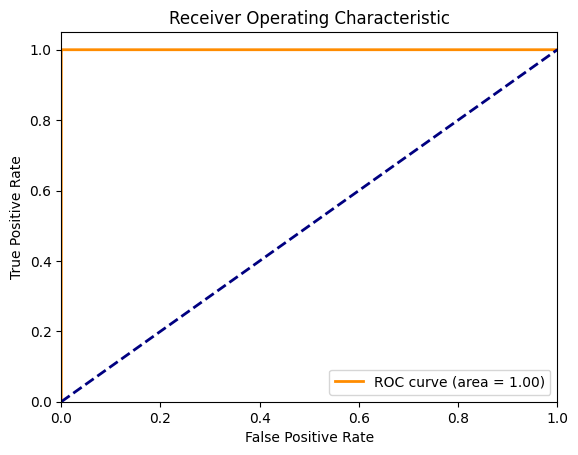

In [11]:
y_pred_proba = rf.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test.map({'BENIGN': 0, 'MALIGN': 1}), y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [12]:
import joblib

joblib_file = "LayerModels/lvl1_rf_model.pkl"
joblib.dump(rf, joblib_file)

print("Model saved to", joblib_file)


Model saved to LayerModels/lvl1_rf_model.pkl


## Nivel 2

Ahora queremos compactar nuestro dataset original a 3 classes, DDoS, PortScan y WebAttack.

In [13]:
X_2 = X[y != 'BENIGN']
y_2 = y[y != 'BENIGN']

target_classes = {
    "Web Attack - Brute Force": 50000,
    "Web Attack - XSS": 50000,
    "Web Attack - Sql Injection": 50000
}

smote = SMOTE(sampling_strategy=target_classes, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_2, y_2)

print(y_resampled.value_counts())

AttackType
PortScan                      158804
DDoS                          128025
Web Attack - Brute Force       50000
Web Attack - XSS               50000
Web Attack - Sql Injection     50000
Name: count, dtype: int64


In [14]:
y_resampled = y_resampled.apply(lambda x: 'WebAttack' if "Web Attack" in x else x)
print(y_resampled.value_counts())

AttackType
PortScan     158804
WebAttack    150000
DDoS         128025
Name: count, dtype: int64


Como los ataques pueden tener cierto tipo de similaridad entre ellos, y ya vimos en el estudio inicial que no hay relaciones lineal entre variables y variable objetivo. El nivel dos usaremos un modelo mas complejo, una NN. Las NN requieren de un preprocesamiento extra:

- **Datos normalizados**: Usaremos MinMaxScaler.

- **Evitar redundancia y ruido**: Si los resultados no son buenos, trataremos esto, ya que puede ser al haber hecho un oversampling tan fuerte.

- **Codificación de etiquetas**: Usaremos LabelEncoding.

In [15]:
scaler = MinMaxScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

X_resampled_scaled = pd.DataFrame(X_resampled_scaled, columns=X_resampled.columns)

X_resampled_scaled.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,436829.000000,4.368290e+05,436829.000000,436829.000000,436829.000000,436829.000000,436829.000000,436829.000000,436829.000000,436829.000000,...,436829.000000,436829.000000,436829.000000,436829.000000,436829.000000,436829.000000,436829.000000,436829.000000,436829.000000,436829.000000
mean,0.048726,5.696206e-02,0.015874,0.023876,0.008814,0.017548,0.077294,0.020820,0.054172,0.071048,...,0.018636,0.712515,0.011773,0.000004,0.011773,0.011772,0.029514,0.020427,0.037254,0.021774
std,0.139010,1.558565e-01,0.087120,0.083442,0.084829,0.063907,0.237774,0.039344,0.153388,0.225241,...,0.091734,0.182372,0.086864,0.001800,0.086866,0.086863,0.115330,0.122943,0.143324,0.101981
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001223,4.423681e-07,0.000000,0.008772,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.001223,4.932713e-03,0.009479,0.008772,0.000041,0.000033,0.003322,0.000000,0.008288,0.000000,...,0.000000,0.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.022940,4.471076e-02,0.009479,0.035088,0.000531,0.005890,0.033223,0.041667,0.029009,0.018794,...,0.019802,0.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
label_encoder = LabelEncoder()
y_resampled_encoded = label_encoder.fit_transform(y_resampled)
unique, counts = np.unique(y_resampled_encoded, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(128025), np.int64(1): np.int64(158804), np.int64(2): np.int64(150000)}


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled_encoded, test_size=0.2, random_state=42)


model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),  # Primera capa oculta con 128 nodos
    Dropout(0.3),  # Dropout para prevenir sobreajuste
    Dense(64, activation='relu'),  # Segunda capa oculta con 64 nodos
    Dropout(0.3),
    Dense(3, activation='softmax')  # Capa de salida para clasificación multiclase (3 clases)
])

# 6. Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',  # Para problemas multiclase
              metrics=['accuracy'])

y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

# Entrenar el modelo
history = model.fit(X_train, y_train_one_hot, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluar el modelo
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/50


/Users/nico/Desktop/UPC/PAE/SentinelX/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8737/8737 ━━━━━━━━━━━━━━━━━━━━ 4s 398us/step - accuracy: 0.9931 - loss: 0.0376 - val_accuracy: 0.9996 - val_loss: 0.0013
Epoch 2/50
8737/8737 ━━━━━━━━━━━━━━━━━━━━ 3s 388us/step - accuracy: 0.9996 - loss: 0.0021 - val_accuracy: 0.9997 - val_loss: 0.0014
Epoch 3/50
8737/8737 ━━━━━━━━━━━━━━━━━━━━ 3s 386us/step - accuracy: 0.9997 - loss: 0.0018 - val_accuracy: 0.9998 - val_loss: 9.1995e-04
Epoch 4/50
8737/8737 ━━━━━━━━━━━━━━━━━━━━ 3s 387us/step - accuracy: 0.9997 - loss: 0.0015 - val_accuracy: 0.9998 - val_loss: 8.7715e-04
Epoch 5/50
8737/8737 ━━━━━━━━━━━━━━━━━━━━ 3s 385us/step - accuracy: 0.9997 - loss: 0.0016 - val_accuracy: 0.9998 - val_loss: 8.6629e-04
Epoch 6/50
8737/8737 ━━━━━━━━━━━━━━━━━━━━ 3s 385us/step - accuracy: 0.9998 - loss: 0.0016 - val_accuracy: 0.9997 - val_loss: 0.0012
Epoch 7/50
8737/8737 ━━━━━━━━━━━━━━━━━━━━ 4s 408us/step - accuracy: 0.9998 - loss: 0.0019 - val_accuracy: 0.9999 - val_loss: 0.0011
Epoch 8/50
8737/8737 ━━━━━━━━━━━━━━━━━━━━ 3s 390us/step - accuracy: 0.9998 

2731/2731 ━━━━━━━━━━━━━━━━━━━━ 1s 226us/step


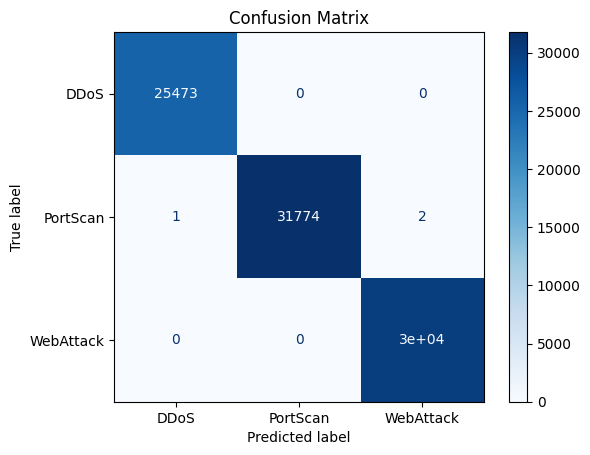

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


In [18]:

# Predict the labels for the test set
y_pred_nn = model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_nn_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Calculate and print other performance metrics
accuracy = accuracy_score(y_test, y_pred_nn_classes)
precision = precision_score(y_test, y_pred_nn_classes, average='weighted')
recall = recall_score(y_test, y_pred_nn_classes, average='weighted')
f1 = f1_score(y_test, y_pred_nn_classes, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Como podemos ver en todas las metricas, los resultados son excelentes en esta detección de ataques por lo que añadiremos en el nivel 2 de la jerarquia este modelo.

In [19]:
import joblib

joblib_file = "LayerModels/lvl2_nn_model.keras"
joblib.dump(model, joblib_file)

print("Model saved to", joblib_file)

Model saved to LayerModels/lvl2_nn_model.keras


2731/2731 ━━━━━━━━━━━━━━━━━━━━ 1s 226us/step


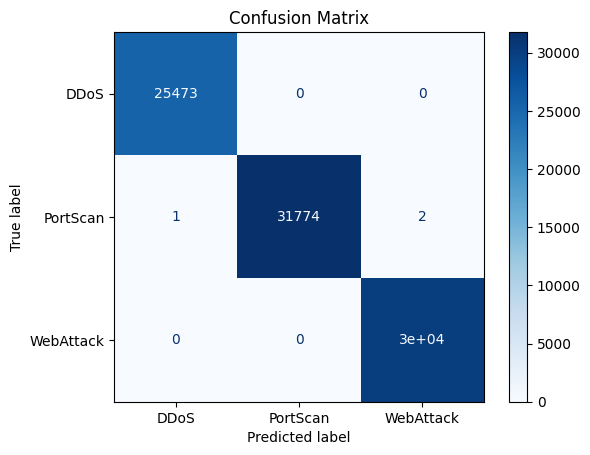

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


In [20]:
nn = tf.keras.models.load_model('LayerModels/lvl2_nn_model.keras')

y_pred_nn = nn.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_nn_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Calculate and print other performance metrics
accuracy = accuracy_score(y_test, y_pred_nn_classes)
precision = precision_score(y_test, y_pred_nn_classes, average='weighted')
recall = recall_score(y_test, y_pred_nn_classes, average='weighted')
f1 = f1_score(y_test, y_pred_nn_classes, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

## Nivel 3

Ahora queremos compactar nuestro dataset original a 3 Brute Force, XSS y SQL Injection. Para llegar a este nivel, se deberá haber conseguido una respuesta MALIGN en el Nivel 1 y WebAttack en el Nivel 2.

In [21]:
X_3 = X_2[(y != 'PortScan') & (y != 'DDoS')]
y_3 = y_2[(y != 'PortScan') & (y != 'DDoS')]

target_classes = {
    "Web Attack - Brute Force": 50000,
    "Web Attack - XSS": 50000,
    "Web Attack - Sql Injection": 50000
}

smote = SMOTE(sampling_strategy=target_classes, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_3, y_3)

print(y_resampled.value_counts())

/var/folders/1c/k17dvp9157q8zrkvz60k2wsm0000gn/T/ipykernel_39830/1064163699.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_3 = X_2[(y != 'PortScan') & (y != 'DDoS')]


AttackType
Web Attack - Brute Force      50000
Web Attack - XSS              50000
Web Attack - Sql Injection    50000
Name: count, dtype: int64


In [22]:
# Reemplazar las etiquetas de las clases Web Attack con una sola clase "WebAttack"
y_resampled = y_resampled.replace({
    "Web Attack - Brute Force": "BruteForce",
    "Web Attack - XSS": "XSS",
    "Web Attack - Sql Injection": "SQLInjection"
})

# Verificar los conteos para asegurarse del cambio
print(y_resampled.value_counts())


AttackType
BruteForce      50000
XSS             50000
SQLInjection    50000
Name: count, dtype: int64


In [23]:
scaler = MinMaxScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

X_resampled_scaled = pd.DataFrame(X_resampled_scaled, columns=X_resampled.columns)

X_resampled_scaled.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,150000.0,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.0,150000.000000,150000.000000,...,150000.000000,150000.0,150000.0,150000.0,150000.0,150000.0,150000.0,150000.0,150000.0,150000.0
mean,0.0,0.075709,0.032093,0.035824,0.025087,0.016773,0.202093,0.0,0.127151,0.190537,...,0.026429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.101546,0.146638,0.139445,0.143361,0.101700,0.374878,0.0,0.244993,0.354401,...,0.153982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.071333,0.009479,0.008772,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.073931,0.009479,0.008772,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.079590,0.009479,0.008772,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
label_encoder = LabelEncoder()
y_resampled_encoded = label_encoder.fit_transform(y_resampled)
unique, counts = np.unique(y_resampled_encoded, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(50000), np.int64(1): np.int64(50000), np.int64(2): np.int64(50000)}


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled_encoded, test_size=0.2, random_state=42)


model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),  # Primera capa oculta con 128 nodos
    Dropout(0.3),  # Dropout para prevenir sobreajuste
    Dense(64, activation='relu'),  # Segunda capa oculta con 64 nodos
    Dropout(0.3),
    Dense(3, activation='softmax')  # Capa de salida para clasificación multiclase (3 clases)
])

# 6. Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',  # Para problemas multiclase
              metrics=['accuracy'])

y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

# Entrenar el modelo
history = model.fit(X_train, y_train_one_hot, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluar el modelo
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/50


/Users/nico/Desktop/UPC/PAE/SentinelX/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 2s 412us/step - accuracy: 0.6727 - loss: 0.5551 - val_accuracy: 0.7644 - val_loss: 0.4552
Epoch 2/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 1s 384us/step - accuracy: 0.7336 - loss: 0.4591 - val_accuracy: 0.7451 - val_loss: 0.4493
Epoch 3/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 1s 392us/step - accuracy: 0.7460 - loss: 0.4498 - val_accuracy: 0.7420 - val_loss: 0.4466
Epoch 4/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 1s 390us/step - accuracy: 0.7526 - loss: 0.4424 - val_accuracy: 0.7529 - val_loss: 0.4419
Epoch 5/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 1s 393us/step - accuracy: 0.7521 - loss: 0.4430 - val_accuracy: 0.7693 - val_loss: 0.4388
Epoch 6/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 1s 394us/step - accuracy: 0.7528 - loss: 0.4411 - val_accuracy: 0.7679 - val_loss: 0.4405
Epoch 7/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 1s 403us/step - accuracy: 0.7504 - loss: 0.4393 - val_accuracy: 0.7530 - val_loss: 0.4384
Epoch 8/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 1s 396us/step - accuracy: 0.7552 - loss: 0.44

938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


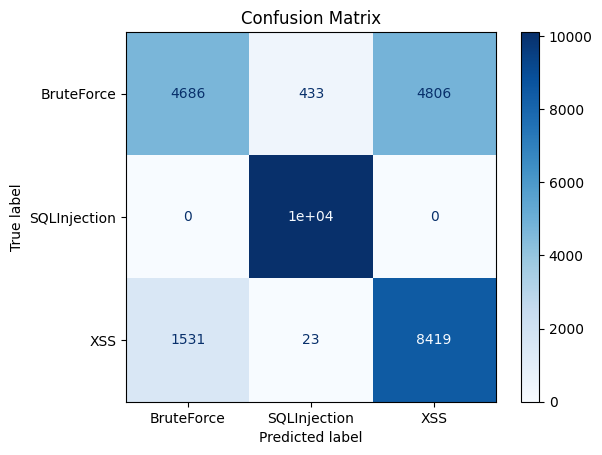

Accuracy: 0.77
Precision: 0.78
Recall: 0.77
F1 Score: 0.76


In [26]:

# Predict the labels for the test set
y_pred_nn = model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_nn_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Calculate and print other performance metrics
accuracy = accuracy_score(y_test, y_pred_nn_classes)
precision = precision_score(y_test, y_pred_nn_classes, average='weighted')
recall = recall_score(y_test, y_pred_nn_classes, average='weighted')
f1 = f1_score(y_test, y_pred_nn_classes, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Como vemos, el rendimiento se ha empobrecido mucho por lo que vamos a intentar con un red neuronal mas compleja 

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled_encoded, test_size=0.2, random_state=42)

# Modelo mejorado
model = Sequential([
    Dense(256, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=l2(0.01)),  # Capa 1 con regularización L2
    BatchNormalization(),  # Normalización de batch
    Dropout(0.4),  # Dropout para prevenir sobreajuste

    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # Capa 2
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # Capa 3
    BatchNormalization(),
    Dropout(0.3),

    Dense(3, activation='softmax')  # Capa de salida para 3 clases
])

# Compilación del modelo
model.compile(optimizer=Adam(learning_rate=0.0005),  # Tasa de aprendizaje ajustada
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Convertir etiquetas a formato one-hot
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Detener si no mejora en 10 epochs
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')  # Guardar el mejor modelo

# Entrenamiento del modelo
history = model.fit(X_train, y_train_one_hot, 
                    epochs=100, 
                    batch_size=64,  # Incrementar batch_size para entrenar más datos de una vez
                    validation_split=0.2, 
                    callbacks=[early_stopping, model_checkpoint],
                    verbose=1)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/100


/Users/nico/Desktop/UPC/PAE/SentinelX/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 965us/step - accuracy: 0.6709 - loss: 2.6108 - val_accuracy: 0.7289 - val_loss: 0.6810
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7180 - loss: 0.6307 - val_accuracy: 0.7185 - val_loss: 0.5887
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - accuracy: 0.7243 - loss: 0.5401 - val_accuracy: 0.7541 - val_loss: 0.4986
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step - accuracy: 0.7341 - loss: 0.5172 - val_accuracy: 0.7564 - val_loss: 0.4908
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - accuracy: 0.7365 - loss: 0.5055 - val_accuracy: 0.7505 - val_loss: 0.4921
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step - accuracy: 0.7387 - loss: 0.5004 - val_accuracy: 0.7466 - val_loss: 0.4768
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 872us/step - accuracy: 0.7386 - loss: 0.5055 - val_accuracy: 0.6842 - val_loss: 0.4999
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 867us/step - accuracy: 0.7440 - loss:

938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


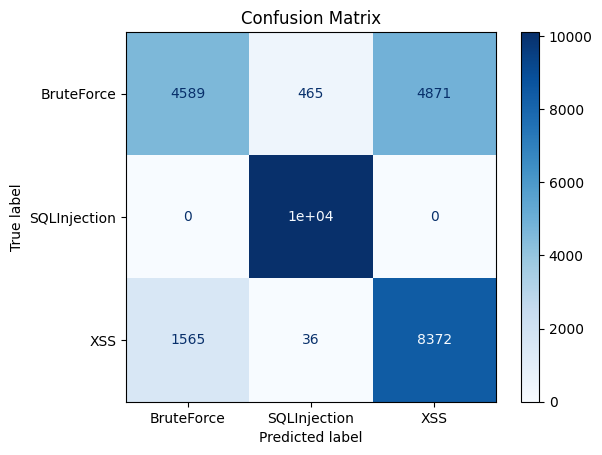

Accuracy: 0.77
Precision: 0.78
Recall: 0.77
F1 Score: 0.76


In [28]:

# Predict the labels for the test set
y_pred_nn = model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_nn_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Calculate and print other performance metrics
accuracy = accuracy_score(y_test, y_pred_nn_classes)
precision = precision_score(y_test, y_pred_nn_classes, average='weighted')
recall = recall_score(y_test, y_pred_nn_classes, average='weighted')
f1 = f1_score(y_test, y_pred_nn_classes, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')